# CSC413 Lab 7: Text Classification using RNNs

**Sentiment Analysis** is the problem of identifying the writer's sentiment given a piece of text.
Sentiment Analysis can be applied to movie reviews, feedback of other forms, emails, tweets,
course evaluations, and much more.

In this lab, we will build an RNN to classify positive vs negative tweets
We use the Sentiment140 data set, which contains tweets with either a positive
or negative emoticon. Our goal is to determine whether which type of
emoticon the tweet (with the emoticon removed) contained. The dataset was actually collected by
a group of students, much like you, who are doing their first machine learning projects.

By the end of this lab, you will be able to:

- Use PyTorch to train an RNN model
- Apply and analyze the components of an RNN model
- Explain how batching is done on sequence data, where the training data in a batch may have different lengths
- Use pre-trained word embeddings as part of a transfer learning strategy for text classification
- Understand the bias that exists in word embeddings and language models.

Acknowledgements:

- Data is sampled from http://help.sentiment140.com/for-students


Please work in groups of 1-2 during the lab.

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab10.ipynb` on Markus
**containing all your solutions to the Graded Task**s.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 1. Your output showing several positive tweets. (1 point)
- Part 2. Your implementation of the RNN. (5 point)
- Part 2. Your explanation of the shapes of `wordemb`. (1 point)
- Part 2. Your explanation of the shapes of `h` and `out`. (2 points)
- Part 3. Your demonstration of the model's ability to "overfit" on a data set. (1 point)
- Part 3. Your output from training the model on the full data set. (1 point)
- Part 3. Your comparison of using a different architecture from before. (2 points)
- Part 4. Your implementation of `MyGloveRnn`. (2 points)
- Part 4. Your explanation of why `MyGloveRNN` requires fewer iteration to obtain "good" accuracy. (1 point)
- Part 4. Your comparison of `MyGloveRNN` and `MyRNN` in low data settings. (1 point)
- Part 4. Your explanation of where the biases in embeddings come from, and whether our model will have the same sorts of biases. (1 point)
- Part 5. Your reflection on the sentiment analysis task. (2 points)


## Part 1. Data

Start by running these two lines of code to download the data on to Google Colab.

In [1]:
# Download tutorial data files.
!wget https://www.cs.toronto.edu/~lczhang/413/sample_tweets.csv

--2024-03-30 16:18:33--  https://www.cs.toronto.edu/~lczhang/413/sample_tweets.csv
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11099815 (11M) [text/csv]
Saving to: ‘sample_tweets.csv’

sample_tweets.csv   100%[===================>]  10.58M  18.8MB/s    in 0.6s    

2024-03-30 16:18:34 (18.8 MB/s) - ‘sample_tweets.csv’ saved [11099815/11099815]



As always, we start by understanding what our data looks like. Notice that the
test set has been set aside for us. Both the training and test set files follow
the same format. Each line in the csv file contains the tweet text,
the string label "4" (positive) or "0" (negative), and some additional information about the tweet.

In [2]:
import csv
datafile = "sample_tweets.csv"

# Training/Validation set
data = csv.reader(open(datafile))
for i, line in enumerate(data):
    print(line)
    if i > 10:
        break

['0', '1467810672', 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY', 'scotthamilton', "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
['0', '1467812025', 'Mon Apr 06 22:20:09 PDT 2009', 'NO_QUERY', 'mimismo', '@twittera que me muera ? ']
['0', '1467812723', 'Mon Apr 06 22:20:19 PDT 2009', 'NO_QUERY', 'TLeC', "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . ."]
['0', '1467813782', 'Mon Apr 06 22:20:34 PDT 2009', 'NO_QUERY', 'gi_gi_bee', '@FakerPattyPattz Oh dear. Were you drinking out of the forgotten table drinks? ']
['0', '1467818481', 'Mon Apr 06 22:21:46 PDT 2009', 'NO_QUERY', 'lionslamb', "He's the reason for the teardrops on my guitar the only one who has enough of me to break my heart "]
['0', '1467824967', 'Mon Apr 06 22:23:28 PDT 2009', 'NO_QUERY', 'playboybacon', "Mo jobs, no money.  how in the hell is min wage here 4 f'n clams an hour?"]
['0', '1467835305', 'Mon Apr 06 2

**Task**: How many positive and negative tweets are in this file?

In [3]:
# TODO
from collections import Counter
print(Counter(x[0] for x in csv.reader(open(datafile))))

Counter({'4': 40197, '0': 39694})


**Graded Task**: We have printed several negative tweets above.
Print 10 positive tweets.

In [4]:
# TODO: Please make sure to include both your code and the
# printed output
import csv
datafile = "sample_tweets.csv"

# Training/Validation set
data = csv.reader(open(datafile))
start = None
for i, line in enumerate(data):
  if line[0] == '4':
    print(line)
    if start == None:
      start = i
    if i - start > 10:
        break

['4', '1467822272', 'Mon Apr 06 22:22:45 PDT 2009', 'NO_QUERY', 'ersle', 'I LOVE @Health4UandPets u guys r the best!! ']
['4', '1467822814', 'Mon Apr 06 22:22:54 PDT 2009', 'NO_QUERY', 'misstoriblack', 'Just added tweetie to my new iPhone ']
['4', '1467822936', 'Mon Apr 06 22:22:57 PDT 2009', 'NO_QUERY', 'adamjackson', "Catching Up on Emails, RSS and Random BACN. Then I'm cutting out early tonight (11:30PM) to have Dinner with @lauraw "]
['4', '1467823405', 'Mon Apr 06 22:23:03 PDT 2009', 'NO_QUERY', 'gattermeier', 'reaching amritsar in an hour and (if i find a bus) should be at wagah border by 2pm  - http://bkite.com/06fuJ']
['4', '1467823919', 'Mon Apr 06 22:23:10 PDT 2009', 'NO_QUERY', 'loveshine', 'YAY! found a new cuddle buddy ']
['4', '1467841923', 'Mon Apr 06 22:27:57 PDT 2009', 'NO_QUERY', 'AishaNH', "@JonathanRKnight hmm you have a lot to say tonight! That's great!  Of course, here I am up late reading it. haha"]
['4', '1467842136', 'Mon Apr 06 22:28:01 PDT 2009', 'NO_QUERY', 

We will now split the dataset into training, validation, and test sets:

In [5]:
# read the data; convert labels into integers
data = [(review, int(label=='4'))  # label 1 = positive, 0 = negative
        for label, _, _, _, _, review in csv.reader(open(datafile))]

# shuffle the data, since the file stores all negative tweets first
import random
random.seed(42)
random.shuffle(data)

train_data = data[:50000]
val_data = data[50000:60000]
test_data = data[60000:]

In [6]:
train_data[10]

("@realdowntomars Check your email. Just sent you the article. Hope it's what you wanted ",
 1)

In order to be able to use neural networks to make predictions about these tweets,
we need to begin by convert these tweets into sequences of numbers, each representing
a words. This is akin to a one-hot encoding: each word will be converted into an
a number representing the unique *index* of that word.

Although we could do this conversion by writing our own python code,
torch has a package called **torchtext** that has utilities useful for text classification
and generation tasks.
In particular, the `Vocab` class and `build_vocab_from_iterator` will be useful for us
for building the mapping from words to indices.

In [7]:
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator

# we will *tokenize* each word by using a tokenzier from
# https://pytorch.org/text/stable/data_utils.html#get-tokenizer

tokenizer = get_tokenizer("basic_english")
train_data_words = [tokenizer(x) for x, t in train_data]

# build the vocabulary object. the parameters to this function
# is described below
vocab = build_vocab_from_iterator(train_data_words,
                                  specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                  min_freq=10)

# set the index of a word not in the vocabulary
vocab.set_default_index(2) # this is the index of the `<unk>` keyword

Now, `vocab` is an object of class `Vocab` (see more here [https://pytorch.org/text/stable/vocab.html](https://pytorch.org/text/stable/vocab.html) )
that provides functionalities for converting words into their indices.
In addition to words appearing in the training set, ther are four special tokens that
we use, akin to placeholder words:

- `<bos>`, to indicate the beginning of a sequence.
- `<eos>`, to indicate the end of a sequence.
- `<unk>`, to indicate a word that is *not* in the vocabulary. This includes
  words that appear too infrequently to be included in the vocabulary, and any
  other words in the validation/test sets that are not see in training.
- `<pad>`, used for padding shorter sequences in a batch: since each tweet
  may have different length, the shorter tweets in each batch will be padded with
  the `<pad>` token so that each sequence (tweet) in a batch has the same length.

The `min_freq` parameter identifies the minimum number of times a word must appear in the
training set in order to be included in the vocabulary.

Here you can see the `vocab` object in action:

In [8]:
# Print the number of words in the vocabulary
print(len(vocab))

# Convert a tweet into a sequence of word indices.
tweet = 'The movie Pneumonoultramicroscopicsilicovolcanoconiosis is a good movie, it is very funny'
tokens = tokenizer(f'<bos> {tweet} <eos>')
print(tokens)
indices = vocab.forward(tokens)
print(indices)

4117
['<bos>', 'the', 'movie', 'pneumonoultramicroscopicsilicovolcanoconiosis', 'is', 'a', 'good', 'movie', ',', 'it', 'is', 'very', 'funny', '<eos>']
[0, 9, 257, 2, 17, 11, 39, 257, 10, 15, 17, 137, 363, 1]


**Task**: What is the index of the `<pad>` token?

In [9]:
# TODO: write code to identify the index of the `<pad>` token
tokens = tokenizer(f'<pad>')
indices = vocab.forward(tokens)
indices

[3]

Now let's apply this transformation to the entire set of training, validation, and test data.

In [10]:

def convert_indices(data, vocab):
    """Convert data of form [(tweet, label)...] where tweet is a string
    into an equivalent list, but where the tweets represented as a list
    of word indices.
    """
    return [(vocab.forward(tokenizer(f'<bos> {text} <eos>')), label)
            for (text, label) in data]

train_data_indices = convert_indices(train_data, vocab)
val_data_indices = convert_indices(val_data, vocab)
test_data_indices = convert_indices(test_data, vocab)

We have seen that PyTorch's `DataLoader` provides an easy way to form minibatches
when we worked with image data. However, text and sequence data is more challenging to
work with since the sequences may not be the same length.

Although we can (and will!) continue to use `DataLoader` for our text data, we need to
provide a function that merges sequences of various lengths into two PyTorch tensors
correspondingg to the inputs and targets for that batch.


**Task**: Following the instructions below, complete the `collate_batch` function,
which creates the input and target tensors
for a batch of data.

In [11]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Returns the input and target tensors for a batch of data

    Parameters:
        `batch` - An iterable data structure of tuples (indices, label),
                  where `indices` is a sequence of word indices, and
                  `label` is either 1 or 0.

    Returns: a tuple `(X, t)`, where
        - `X` is a PyTorch tensor of shape (batch_size, sequence_length)
        - `t` is a PyTorch tensor of shape (batch_size)
    where `sequence_length` is the length of the longest sequence in the batch
    """

    text_list = []  # collect each sample's sequence of word indices
    label_list = [] # collect each sample's target labels
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        # TODO: what do we need to do with `label`?
        # print(label)
        label_list.append(label)
    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.tensor(label_list) # TODO
    return X, t


train_dataloader = DataLoader(train_data_indices, batch_size=10, shuffle=True,
                              collate_fn=collate_batch)

With the above code in mind, we should be able to extract batches from `train_dataloader`.
Notice that `X.shape` is different in each batch.
You should also see that the index `3` is used to pad shorter sequences in in a batch.

In [12]:
for i, (X, t) in enumerate(train_dataloader):
    print(X.shape, t.shape)
    if i >= 10:
        break

print(X)

torch.Size([10, 32]) torch.Size([10])
torch.Size([10, 29]) torch.Size([10])
torch.Size([10, 37]) torch.Size([10])
torch.Size([10, 30]) torch.Size([10])
torch.Size([10, 37]) torch.Size([10])
torch.Size([10, 31]) torch.Size([10])
torch.Size([10, 37]) torch.Size([10])
torch.Size([10, 39]) torch.Size([10])
torch.Size([10, 41]) torch.Size([10])
torch.Size([10, 34]) torch.Size([10])
torch.Size([10, 39]) torch.Size([10])
tensor([[   0, 2105,  204,   10,   27,   65,  921,    2,  433,   29,   65,  177,
          277,   25,  165,    7,   20,    2,  810,   16,    1,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3],
        [   0,  116,   30, 4108,   40,  167,   11,  137,    2,   92,    7,   20,
          129,    1,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3],
        [   0, 1139,   11,   91,  326,  

**Task**: Why does each sequence begin with the token `0`, and end with the token `1` (ignoring
the paddings).

In [13]:
# TODO: Your explanation goes here
tokens = tokenizer(f'<bos> <eos>')
indices = vocab.forward(tokens)
indices

[0, 1]

## Part 2. Model

We will use a recurrent neural network model to classify positive vs negative
sentiments. Our RNN model will have three components that are typical in a
sequence classification model:

- An *embedding layer*, which will map each word index (akin to a one-hot embedding)
  into a low-dimensional vector. This layer as having the same functionality as the
  weights $W^{(word)}$ from lab 2.
- A *recurrent layer*, which performs the recurrent neural network computation.
  The input to this layer is the low-dimensional embedding vectors
  for each word in the sequence.
- A *fully connected layer*, which computes the final binary classification using
  features computed from the recurrent layer. Think about how you can combine the per-timestep
  output of the RNN into one final prediction.

Let's define the model that we will use, and then explore it step by step.

**Graded Task**: Implement the forward pass of the model and the RNN component.

In [14]:
import torch.nn as nn

class MyRNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_classes):
        super(MyRNN, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.emb = nn.Embedding(vocab_size, emb_size)
        # TODO: Your code here
        self.rnn = nn.RNN(input_size=emb_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def custom_function(self, rnn_out, hidden):
        # Example custom function
        output = torch.sum(rnn_out, dim=1)  # Sum over sequence dimension
        return output

    def forward(self, X):
        # TODO: Your code here
        # X shape: (batch_size, seq_length)
        embedded = self.emb(X)  # shape: (batch_size, seq_length, emb_size)
        # Initialize hidden state
        h0 = torch.zeros(1, X.size(0), self.hidden_size)  # shape: (1, batch_size, hidden_size)
        # Forward propagate RNN
        out, hidden = self.rnn(embedded, h0)  # h shape: (batch_size, seq_length, hidden_size)
        # Extract the output of the last timestep
        out_last = out[:, -1, :]  # shape: (batch_size, hidden_size)
        # Fully connected layer
        output = self.custom_function(out, hidden)
        # print("out_last.shape", out_last.shape)
        logits = self.fc(output)  # shape: (batch_size, num_classes)
        return logits


model = MyRNN(len(vocab), 128, 64, 2)

To explore exactly what this model is doing, let's grab one batch of data from
the data loader we created. We will observe, step-by-step, what computation will be
performed on the input `X` to obtain the final prediction. We do this by
emulating the `forward` method of the `MyRNN` function.

In [15]:
X, t = next(iter(train_dataloader))

print(X.shape)

torch.Size([10, 37])


**Graded Task**: Run the code below to check the shape of `wordemb`.
What shape does this tensor have?  Explain what each dimension in this shape means.

In [16]:
wordemb = model.emb(X)

print(wordemb.shape)

# TODO: Include your explanation here

torch.Size([10, 37, 128])


My answer:
The shape is [10, 33, 128], which means (batch_size, seq_length, emb_size).

- batch_size: This dimension corresponds to the number of sequences in the input batch. Each sequence in the batch is processed independently in parallel. For example, if the batch size is 32, it means that there are 32 sequences being processed simultaneously.

- seq_length: This dimension represents the length of each sequence in terms of the number of tokens or words. It indicates how many words are in each input sequence. For example, if the sequence length is 10, it means that each input sequence contains 10 words.

- emb_size: This dimension represents the size of the word embeddings. It indicates the dimensionality of the embedding space in which words are represented. For example, if emb_size is 128, it means that each word is represented as a vector of length 128 in the embedding space.

**Graded Task**: Run the code below, which computes the RNN forward pass,
with `wordemb` as input.
What shape do the tensors `h` and `out` have?  Explain what these tensors correspond to.
(See the RNN reference [https://pytorch.org/docs/stable/generated/torch.nn.RNN.html](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) on the PyTorch documentation page.)

In [17]:
# If you get a problem here, rename your recurrent unit ;)
h, out = model.rnn(wordemb)

print(h.shape)
print(out.shape)

# The tensors `h` and `out` are related. To see the relation,
# choose an index in the batch and compare the following two
# vectors in `h` and `out`.
index = 2 # choose an index to iterate through the batch
print(h[index, -1, :])
print(out[0, index, :])

# TODO: Include your explanation here

torch.Size([10, 37, 64])
torch.Size([1, 10, 64])
tensor([-0.0546,  0.7891, -0.7420,  0.2971, -0.7308, -0.7699,  0.4171, -0.7351,
         0.3793, -0.9669, -0.5736,  0.2684,  0.3465,  0.8448, -0.7111, -0.4195,
        -0.9323, -0.3446, -0.1732, -0.8730, -0.2478, -0.9307,  0.6578, -0.9414,
         0.8181, -0.3356, -0.4635,  0.9843, -0.8448, -0.5704, -0.7658,  0.9656,
         0.5912,  0.6351, -0.3865, -0.8565,  0.7010, -0.3427,  0.2505,  0.8604,
        -0.4211,  0.0033,  0.4644,  0.0904,  0.7194, -0.0650,  0.0175,  0.1515,
         0.6145,  0.9566,  0.1839,  0.6982, -0.8738, -0.6254, -0.8931, -0.4562,
         0.5627, -0.8950, -0.8991,  0.2966, -0.7550,  0.5402,  0.1595, -0.6293],
       grad_fn=<SliceBackward0>)
tensor([-0.0546,  0.7891, -0.7420,  0.2971, -0.7308, -0.7699,  0.4171, -0.7351,
         0.3793, -0.9669, -0.5736,  0.2684,  0.3465,  0.8448, -0.7111, -0.4195,
        -0.9323, -0.3446, -0.1732, -0.8730, -0.2478, -0.9307,  0.6578, -0.9414,
         0.8181, -0.3356, -0.4635,  0

My answer: h has shape [10, 33, 64] and `out` has shape [1, 10, 64]. h represents the hidden states of the recurrent units (RNN cells) at each time step for each sequence in the batch. The dimensions of h are (batch_size, seq_length, hidden_size). `out` tensor represents the output of the RNN at each time step for each sequence in the batch. It's shape is (num_of_layer, batch_size, hidden_size).

`h[index, -1, :]` selects the hidden state vector of the RNN cell at the last time step (-1) for the sequence at index `index` in the batch from the h tensor. `out[0, index, :]` selects the hidden state vector of the RNN cell at the last time step for the sequence at index index in the batch from the out tensor. The two selected vectors represent the same hidden state information, but they are accessed differently due to the structure of the tensors. The comparison is made to confirm that they contain the same information.



There is one more thing we need to do before training the model, which is
to write a function to estimate the accuracy of the model. This is done for
you below.

In [18]:
# if you get a problem here, check how you implemented the output of your model
def accuracy(model, dataset, max=1000):
    """
    Estimate the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
        `max`     - The max number of samples to use to estimate
                    model accuracy

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,  # use batch size 1 to prevent padding
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total   += 1
        if i >= max:
            break
    return correct / total

accuracy(model, train_data_indices) # should be close to half

0.5064935064935064

## Part 3. Training

In this section, we will train the `MyRNN` model to classify tweets.
As the models that we are building begin to increase in complexity, it is important
to use good debugging techniques. In this section, we will introduce the technique of
checking whether the model and training code is able to overfit on a small training set.
This is a way to check for bugs in the implementation.

**Task**: Complete the training code below

In [19]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model,                # an instance of MLPModel
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate_batch,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):

                z = model(texts) # TODO
                # y = torch.argmax(z, axis=1)
                # print(z.shape, labels.shape)
                loss = criterion(z, labels) # TODO

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)

    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

**Graded Task**: As a way to check the model and training code,
check if your model can obtain a 100\% training accuracy relatively quickly
(e.g. within less than a minute of training time), when training on only the
first 20 element of the training data.

In [20]:
train_dataloader

50 Loss: 0.002354108728468418 Train Acc: 0.85 Val Acc: 0.55
100 Loss: 0.0010290031787008047 Train Acc: 0.85 Val Acc: 0.55
150 Loss: 0.000853641249705106 Train Acc: 0.85 Val Acc: 0.55
200 Loss: 0.000720566778909415 Train Acc: 0.9 Val Acc: 0.55
250 Loss: 0.0006130588008090854 Train Acc: 0.9 Val Acc: 0.55
300 Loss: 0.0005260153557173908 Train Acc: 0.95 Val Acc: 0.55
350 Loss: 0.0004551800375338644 Train Acc: 0.95 Val Acc: 0.55
400 Loss: 0.00039711323915980756 Train Acc: 0.95 Val Acc: 0.55
450 Loss: 0.0003491341194603592 Train Acc: 0.95 Val Acc: 0.55
500 Loss: 0.0003091195540037006 Train Acc: 0.95 Val Acc: 0.55
Training Time: 23.930009126663208 seconds


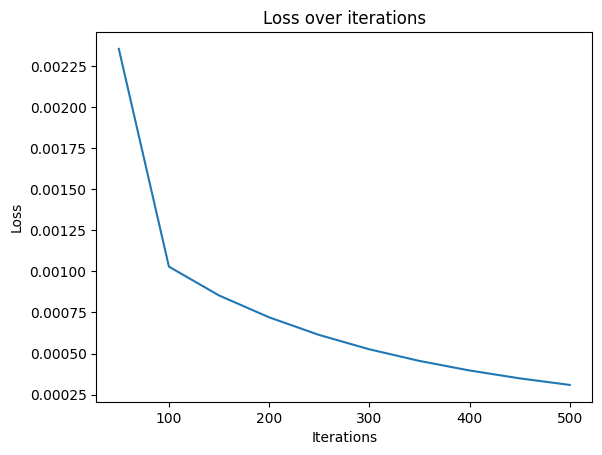

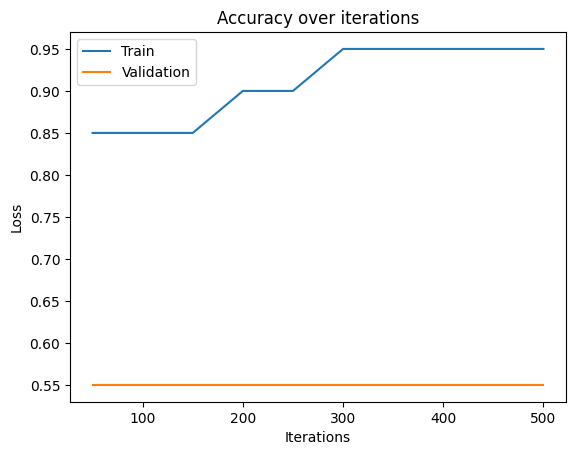

In [21]:
model = MyRNN(vocab_size=len(vocab),
              emb_size=300,
              hidden_size=64,
              num_classes=2)
# TODO: Include your code and output
import time
# Train the model
start_time = time.time()
train_model(model, train_data_indices[:20], val_data_indices[:20], learning_rate=0.001, num_epochs=500)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

**Task**: Will this model that you trained above have a high accuracy over
the validation set? Explain why or why not.

In [22]:
# TODO: Your explanation goes here

**Graded Task**: Train your model on the full data set. What validation accuracy
can you achieve? (Our implementation achieved just shy of 80% without much tuning of HPs, can you match this?)

50 Loss: 0.8286576271057129 Train Acc: 0.5864135864135864 Val Acc: 0.5844155844155844
100 Loss: 0.7215641736984253 Train Acc: 0.6373626373626373 Val Acc: 0.6083916083916084
150 Loss: 0.5805129408836365 Train Acc: 0.6773226773226774 Val Acc: 0.6553446553446554
200 Loss: 0.5400444269180298 Train Acc: 0.6993006993006993 Val Acc: 0.6963036963036963
250 Loss: 0.5888807773590088 Train Acc: 0.7462537462537463 Val Acc: 0.6963036963036963
300 Loss: 0.62200528383255 Train Acc: 0.7482517482517482 Val Acc: 0.7272727272727273
350 Loss: 0.6874615550041199 Train Acc: 0.7642357642357642 Val Acc: 0.7372627372627373
400 Loss: 0.6104104518890381 Train Acc: 0.7652347652347652 Val Acc: 0.7332667332667333
450 Loss: 0.5364484786987305 Train Acc: 0.7822177822177823 Val Acc: 0.7432567432567433
500 Loss: 0.49596184492111206 Train Acc: 0.7742257742257742 Val Acc: 0.7382617382617382
550 Loss: 0.5074366927146912 Train Acc: 0.7932067932067932 Val Acc: 0.7542457542457542
600 Loss: 0.48876500129699707 Train Acc: 0.79

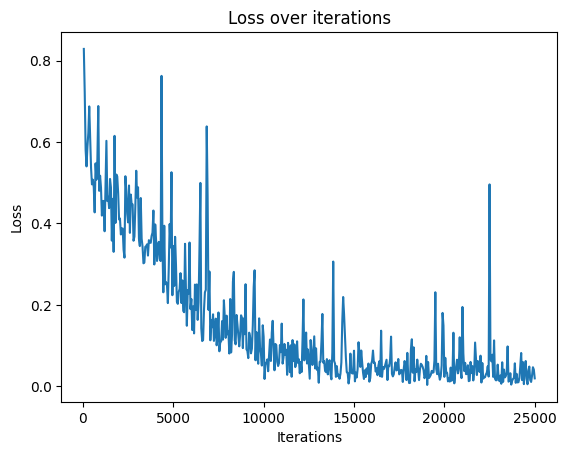

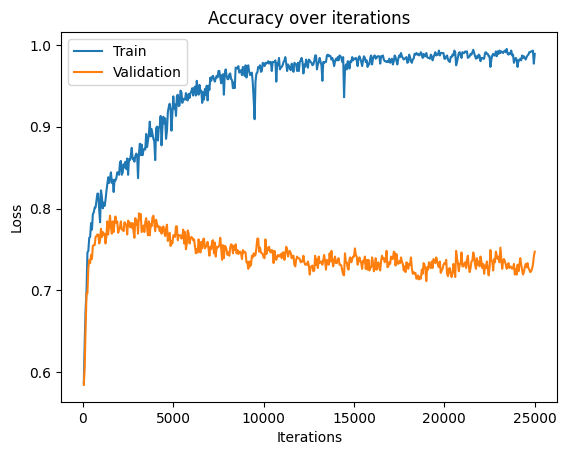

In [23]:
# TODO: Include your code here. Try a few hyperparameter choices until you
# are satisfied that your model performance is reasonable (i.e. no obviously
# poor hyperparameter choices)
model = MyRNN(vocab_size=len(vocab),
              emb_size=300,
              hidden_size=64,
              num_classes=2)
# TODO: Include your code and output
import time
# Train the model
start_time = time.time()
train_model(model, train_data_indices, val_data_indices, learning_rate=0.001, num_epochs=50)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

**Graded task:** There are several different variants of RNN architectures. Chose a *different one* from the one you used previously and reimplement the model and the training loop below. It is OK to copy/paste the majority of the code. Make sure you have train and eval loss as before. Compare the final validation accuracy and comment on whether you obtained the expected results. Why/why not?

50 Loss: 0.6950250267982483 Train Acc: 0.5104895104895105 Val Acc: 0.5234765234765235
100 Loss: 0.6959137916564941 Train Acc: 0.5144855144855145 Val Acc: 0.5064935064935064
150 Loss: 0.6906650066375732 Train Acc: 0.5144855144855145 Val Acc: 0.5064935064935064
200 Loss: 0.6893408298492432 Train Acc: 0.5144855144855145 Val Acc: 0.5064935064935064
250 Loss: 0.699489951133728 Train Acc: 0.5144855144855145 Val Acc: 0.5064935064935064
300 Loss: 0.6978127956390381 Train Acc: 0.5144855144855145 Val Acc: 0.5064935064935064
350 Loss: 0.696076512336731 Train Acc: 0.5144855144855145 Val Acc: 0.5064935064935064
400 Loss: 0.6898492574691772 Train Acc: 0.5534465534465535 Val Acc: 0.5384615384615384
450 Loss: 0.5803149342536926 Train Acc: 0.6873126873126874 Val Acc: 0.6753246753246753
500 Loss: 0.5138512849807739 Train Acc: 0.7412587412587412 Val Acc: 0.7152847152847153
550 Loss: 0.46824637055397034 Train Acc: 0.7572427572427572 Val Acc: 0.7322677322677322
600 Loss: 0.5400914549827576 Train Acc: 0.776

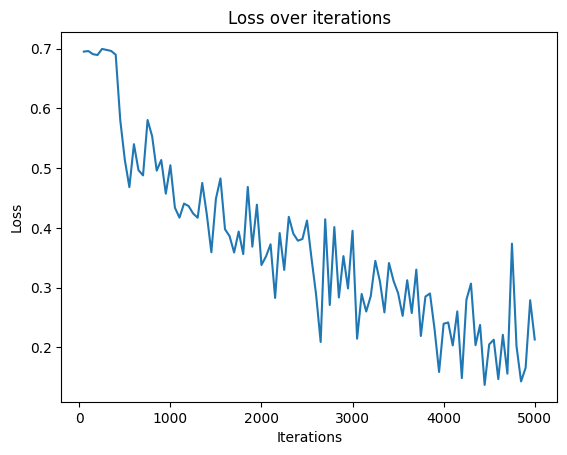

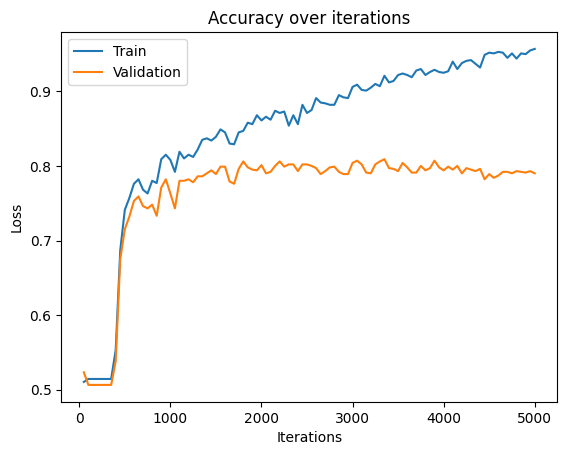

In [25]:
# TODO: Your code here
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

class MyLSTM(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_classes):
        super(MyLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.emb(X)
        lstm_out, _ = self.lstm(embedded)
        output = lstm_out[:, -1, :]  # Use the last timestep's output
        logits = self.fc(output)
        return logits

def train_model(model,                # an instance of MLPModel
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=batch_size,
                                                collate_fn=collate_batch,
                                                shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):

                z = model(texts) # TODO
                # y = torch.argmax(z, axis=1)
                # print(z.shape, labels.shape)
                loss = criterion(z, labels) # TODO

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)

    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

# Example usage:
# Assuming train_loader and val_loader are DataLoader instances for training and validation data
model = MyLSTM(vocab_size=len(vocab), emb_size=128, hidden_size=64, num_classes=2)
train_model(model, train_data_indices, val_data_indices, num_epochs=10)


My answer: The validation accuracy is higher than simple RNN network which is expected. This is because LSTMs are designed to capture long-term dependencies in sequential data better than traditional RNNs. They achieve this by having a gating mechanism that regulates the flow of information, allowing them to retain relevant information over longer sequences. This capability helps LSTMs to learn more complex patterns and dependencies in the data.

## Part 4. Pretrained Embeddings

As we saw in the previous lab on images, **transfer learning** is a useful technique
in practical machine learning, especially in low-data settings:
instead of training an entire neural network from scratch, we use (part of) a
model that is pretrained on large amounts of similar data. We use the intermediate
state of this pretrained model as features to our model---i.e. we use the pretrained
models to compute *features*.

Just like with images, using a pretrained model is an important strategy for working
with text. Large language models is an excellent demonstration of how generalizable
pretrained features can be.

In this part of the lab, we will use a slightly older idea of using pretrained *word embeddings*.
In particular, instead of training our own `nn.Embedding` layer, we will use
GloVe embeddings (2014) [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)
trained on a large data set containing all of Wikipedia and other webpages.

Nowadays, large language model (LLMs), including those with APIs provided by various organizations,
can also be used to map words/sentences into embeddings.
However, the basic idea of using pretrained models in low-data settings remains similar.
We will also identify some bias issues with pretrained word embeddings.
There is evidence that these types of bias issues
continues to persist in LLMs as well.

In [26]:
from torchtext.vocab import GloVe

glove = torchtext.vocab.GloVe(name="6B", dim=300)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [01:05<00:00, 6103.51it/s]


**Task**: Run the below code to print the GloVe word embedding for the word "cat".

In [27]:
print(glove['cat'])

tensor([-0.2935,  0.3325, -0.0474, -0.1225,  0.0720, -0.2341, -0.0624, -0.0037,
        -0.3946, -0.6941,  0.3673, -0.1214, -0.0445, -0.1527,  0.3486,  0.2293,
         0.5436,  0.2521,  0.0980, -0.0873,  0.8706, -0.1221, -0.0798,  0.2871,
        -0.6856, -0.2727,  0.2206, -0.7575,  0.5629,  0.0914, -0.7100, -0.3142,
        -0.5683, -0.2668, -0.6010,  0.2696, -0.1799,  0.1070, -0.5786,  0.3816,
        -0.6713,  0.1093,  0.0794,  0.0224, -0.0811,  0.0112,  0.6709, -0.1909,
        -0.3368, -0.4847, -0.3541, -0.1521,  0.4450,  0.4638,  0.3841,  0.0451,
        -0.5908,  0.2176,  0.3858, -0.4457,  0.0093,  0.4420,  0.0971,  0.3801,
        -0.1188, -0.4272, -0.3101, -0.0251,  0.1269, -0.1347,  0.1198,  0.7625,
         0.2524, -0.2693,  0.0686, -0.1007,  0.0111, -0.1853,  0.4498, -0.5751,
         0.1228, -0.0649,  0.0445, -0.0210, -0.0698, -0.4733, -0.4307,  0.3916,
        -0.0478, -0.9366, -0.5513, -0.1422, -0.1583,  0.1562,  0.0705,  0.1989,
         0.1894, -0.1934, -0.4659, -0.02

Unfortunately, it is not straightforward to add the `<pad>`, `<unk>`, `<bos>` and `<eos>`
tokens. So we will do without them.

**Task**: Run the below code to look up GloVe word indices for the training, validation, and
test sets.

In [28]:
def convert_indices_glove(data, default=len(glove)-1):
    result = []
    for text, label in data:
        words = tokenizer(text) # for simplicity, we wont use <bos> and <eos>
        indices = []
        for w in words:
            if w in glove.stoi:
                indices.append(glove.stoi[w])
            else:
                # this is a bit of a hack, but we will repurpose *last* word
                # (least common word) appearing in the GloVe vocabluary as our
                # '<pad>' token
                indices.append(default)
        result.append((indices, label),)
    return result

train_data_glove = convert_indices_glove(train_data)
val_data_glove = convert_indices_glove(val_data)
test_data_glove = convert_indices_glove(test_data)

**Graded task**: Now, we will modify the `MyRNN` to use the pretrained GloVe vectors. Make sure to not update the glove embeddings. You can reuse code from above.

In [31]:
class MyGloveRNN(nn.Module):
    def __init__(self,  hidden_size, num_classes):
        super(MyGloveRNN, self).__init__()
        self.vocab_size, self.emb_size = glove.vectors.shape
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        # TODO: Your code here
        self.emb = nn.Embedding.from_pretrained(glove.vectors, padding_idx=len(glove)-1)
        self.rnn = nn.RNN(input_size=self.emb_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def custom_function(self, rnn_out, hidden):
        # Example custom function
        output = torch.sum(rnn_out, dim=1)  # Sum over sequence dimension
        return output

    def forward(self, X):
        # TODO: Your code here
        embedded = self.emb(X)
        out, hidden = self.rnn(embedded)
        output = self.custom_function(out, hidden)
        logits = self.fc(output)  # Apply fully connected layer to the last hidden state
        return logits

    def parameters(self):
        # do not return the parameters of self.emb
        # TODO: Your code here
        return [param for name, param in self.named_parameters() if "emb" not in name]


model = MyGloveRNN(64, 2)

- self.named_parameters(): This method returns an iterator over all parameters of the model along with their names.

- The list comprehension iterates over each (name, param) pair returned by self.named_parameters().

- For each pair, it checks if the substring "emb" is not present in the parameter name ("emb" not in name).
If the substring "emb" is not present in the name, it includes the parameter in the list.

- Finally, it returns a list containing only those parameters whose names do not contain the substring "emb".

**Task** Train this model. Use comparable hyperparameters so that you can compare
your result against `MyRNN`.

50 Loss: 0.82370924949646 Train Acc: 0.6103896103896104 Val Acc: 0.5904095904095904
100 Loss: 0.6477293968200684 Train Acc: 0.6703296703296703 Val Acc: 0.6483516483516484
150 Loss: 0.9003347158432007 Train Acc: 0.6273726273726273 Val Acc: 0.6183816183816184
200 Loss: 0.5968431830406189 Train Acc: 0.6933066933066933 Val Acc: 0.6723276723276723
250 Loss: 0.5572295188903809 Train Acc: 0.6843156843156843 Val Acc: 0.6953046953046953
300 Loss: 0.6792323589324951 Train Acc: 0.6843156843156843 Val Acc: 0.7062937062937062
350 Loss: 0.7258193492889404 Train Acc: 0.6963036963036963 Val Acc: 0.7142857142857143
400 Loss: 0.5997798442840576 Train Acc: 0.7182817182817183 Val Acc: 0.7192807192807192
450 Loss: 0.6346414089202881 Train Acc: 0.7022977022977023 Val Acc: 0.7152847152847153
500 Loss: 0.6425125002861023 Train Acc: 0.6893106893106893 Val Acc: 0.7202797202797203
550 Loss: 0.6270362138748169 Train Acc: 0.7242757242757243 Val Acc: 0.7222777222777222
600 Loss: 0.6852171421051025 Train Acc: 0.6953

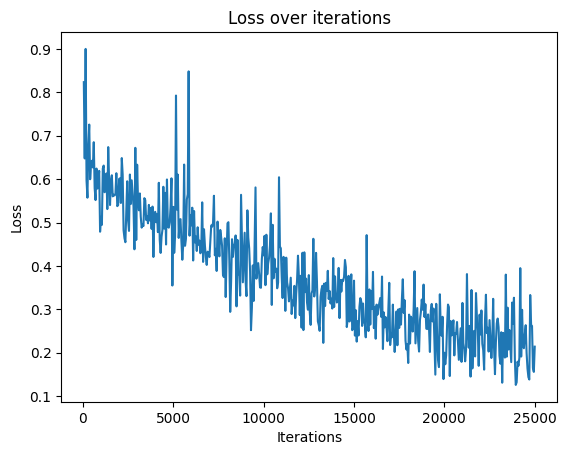

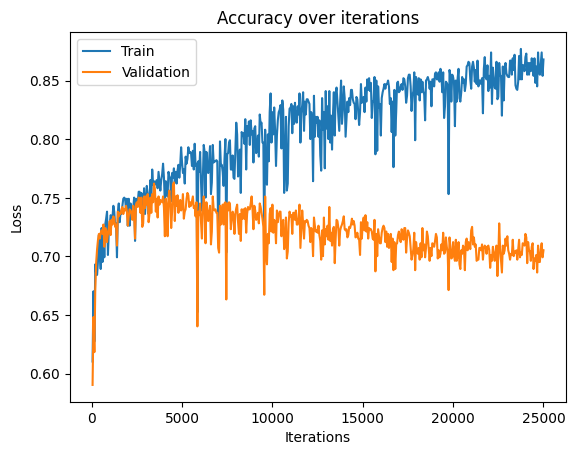

In [32]:
# TODO: Train your model here, and include the output
train_model(model, train_data_glove, val_data_glove, learning_rate=0.001, num_epochs=50)


**Graded Task**: You might notice that a *very* smaller number of
iterations will be required to train this model to a reasonable
performance (e.g. >70% validation accuracy). Why might this be?

In [33]:
# TODO: Include your explanation here

My answer: Pre-trained word embeddings, such as GloVe or Word2Vec, are trained on large corpora with vast amounts of text data. They capture semantic relationships and word contexts from this extensive training data. By initializing the embedding layer with pre-trained word vectors, the model starts with representations that already contain valuable semantic information. This initialization provides a strong starting point for the training process, enabling the model to learn faster and converge more quickly to a reasonable performance level.

**Graded Task**: Train both MyGloveRNN and MyRNN models using the corresponding
embeddings (pretrained vs. not), **but only with the first 200 data points in the
training set**. How do the validation accuracies compare between these two models?

5 Loss: 0.027507705613970757 Train Acc: 0.96 Val Acc: 0.655
10 Loss: 0.04376372694969177 Train Acc: 0.975 Val Acc: 0.68
15 Loss: 0.004436281975358725 Train Acc: 0.95 Val Acc: 0.665
20 Loss: 0.007747025694698095 Train Acc: 0.94 Val Acc: 0.68
25 Loss: 0.0033485509920865297 Train Acc: 0.965 Val Acc: 0.67
30 Loss: 0.002421567915007472 Train Acc: 0.98 Val Acc: 0.68
35 Loss: 0.0020600161515176296 Train Acc: 0.98 Val Acc: 0.68
40 Loss: 0.001857645926065743 Train Acc: 0.98 Val Acc: 0.7


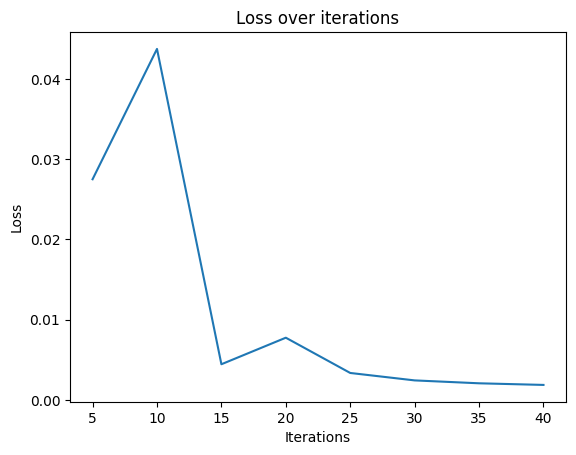

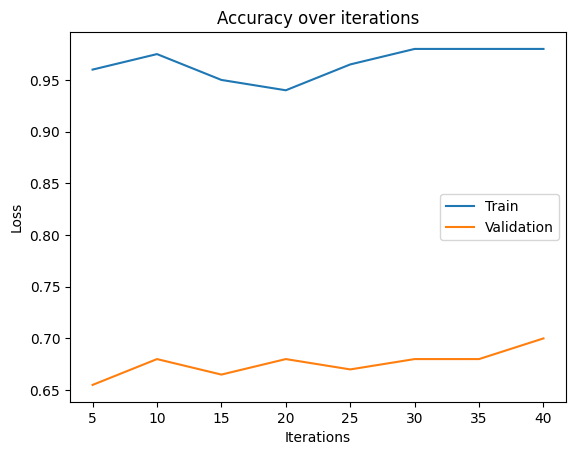

In [40]:
# TODO: Training code for MyGloveRNN.
# Include outputs and training curves in your submission
train_model(model, train_data_glove[:200], val_data_glove[:200], learning_rate=0.001, plot_every=5, num_epochs=20)


5 Loss: 4.553229808807373 Train Acc: 0.495 Val Acc: 0.495
10 Loss: 2.3301968574523926 Train Acc: 0.525 Val Acc: 0.505
15 Loss: 1.527097463607788 Train Acc: 0.56 Val Acc: 0.515
20 Loss: 1.0196590423583984 Train Acc: 0.61 Val Acc: 0.555
25 Loss: 0.8727005124092102 Train Acc: 0.63 Val Acc: 0.545
30 Loss: 0.6740896105766296 Train Acc: 0.67 Val Acc: 0.545
35 Loss: 0.5364856719970703 Train Acc: 0.7 Val Acc: 0.535
40 Loss: 0.5176493525505066 Train Acc: 0.725 Val Acc: 0.54


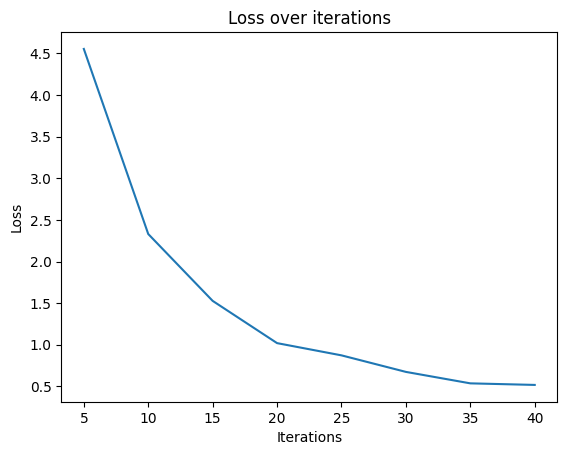

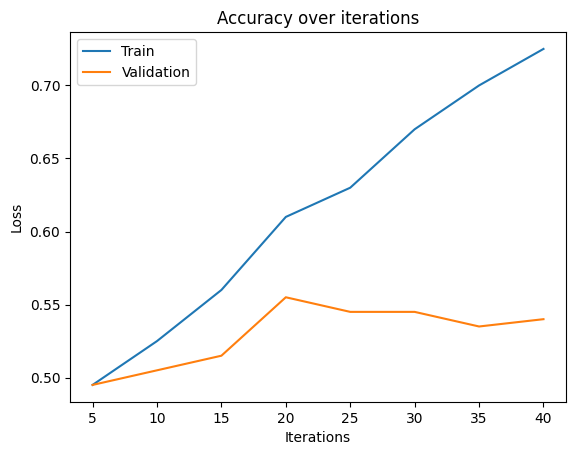

In [42]:
# TODO: Training code for MyRNN
# Include outputs and training curves in your submission
train_model(MyRNN(len(vocab), 128, 64, 2), train_data_indices[:200], val_data_indices[:200], learning_rate=0.001, plot_every=5, num_epochs=20)


In [36]:
# TODO: Compare the validation accuaries here

My answer: The training and validation accuracy is both higher for MyGloveRNN by around 10-20%.

Machine learning models have an air of "fairness" about them, since models
make decisions without human intervention. However, models can and do learn
whatever bias is present in the training data.
GloVe vectors seems innocuous enough: they are just representations of
words in some embedding space. Even so, we will show that the structure
of the GloVe vectors encodes the everyday biases present in the texts
that they are trained on.

We start with an example analogy to demonstrate the power of GloVe embeddings
that allows us to complete analogies by applying arithmetic operations
to the word vectors.

$$doctor - man + woman \approx ??$$

To find the answers to the above analogy, we will compute the following vector,
and then find the word whose vector representation is *closest* to it.

In [43]:
v = glove['doctor'] - glove['man'] + glove['woman']

**Task**: Run the code below to find the closets word. You should see the word
"nurse" fairly high up in that list.

In [44]:
def print_closest_words(vec, n=5):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    for idx, difference in lst[1:n+1]: 					       # take the top n
        print(glove.itos[idx], difference)

print_closest_words(v)

physician 6.7226787
nurse 6.7791734
woman 6.8218
doctors 6.963807
dentist 7.3165383


**Task**:  To compare, use a similar method to find the answer to this analogy:
$$doctor - woman + man \approx ??$$

In other words, we go the opposite direction in the "gender" axis to check
if similarly concerning analogies exist.

In [45]:
print_closest_words(glove['doctor'] - glove['woman'] + glove['man'])

man 6.614642
physician 6.8267035
he 7.064041
mr. 7.065585
dr. 7.127458


**Task**: Compare the following two outputs.

In [46]:
print_closest_words(glove['programmer'] - glove['man'] + glove['woman'])

programmers 6.906153
oly-2004-fhockey 7.1117373
http://www.nwguild.org 7.271939
bb94 7.282604
homemaker 7.296883


In [47]:
print_closest_words(glove['programmer'] - glove['woman'] + glove['man'])

programmers 6.8631363
_____________________________________________ 7.49171
timewrn 7.4950824
jahch 7.561946
jihb 7.5969725


**Task**: Compare the following two outputs.

In [48]:
print_closest_words(glove['professor'] - glove['man'] + glove['woman'])

lecturer 6.5699987
sociology 6.942095
university 6.985767
graduate 7.2252293
researcher 7.289195


In [49]:
print_closest_words(glove['professor'] - glove['woman'] + glove['man'])

university 7.084462
prof. 7.0947814
emeritus 7.146991
harvard 7.289809
sociology 7.330031


**Task**: Compare the following two outputs.

In [50]:
print_closest_words(glove['engineer'] - glove['man'] + glove['woman'])

technician 6.738221
engineers 7.143567
educator 7.160228
worker 7.294498
woman 7.3743315


In [51]:
print_closest_words(glove['engineer'] - glove['woman'] + glove['man'])

engineers 7.340744
mechanic 7.6183243
engineering 7.689247
worked 7.8743134
technician 7.9948106


**Graded Task**: Explain where the bias in these embeddings come from.
Would you expect our word embeddings (trained on tweets) to be similarly
problematic? Why or why not?

In [52]:
# TODO: Your explanation goes here

My answer: Word embeddings are trained on vast amounts of text data collected from various sources, including books, articles, social media, and online forums. These texts often contain implicit biases and prejudices that reflect the attitudes and perspectives of the individuals who authored them. Biases can arise from factors such as cultural norms, societal inequalities, and historical prejudices embedded in the language. For example, it is likely that many sentences that contain 'doctor' and 'woman' and don't contain 'man' would contain 'nurse' as well, likely because there are more female nurses and male nurses.

## Questioning your data's assumptions

**Graded Task:** The task we attempted in this lab is "sentiment analysis". However, the "sentiment" of a short text snippet such as a tweet can be hard to estimate. Give at least 2 reasons for why sentiment analysis can be difficult. Consider the data itself, the labelling task, and the model training. This is an open ended task, so we will grade you not on giving the most correct response, but for making a (very) short but succinct argument for problems you can think of.

In [53]:
# TODO: Your explanation goes here

My answer:

- Subjectivity and Context Dependence: Sentiment analysis relies on interpreting the emotional tone or polarity of text, which can be highly subjective and context-dependent. The same text snippet may be interpreted differently by different individuals based on their personal experiences, cultural background, and social context.

- Ambiguity and Polysemy: Text data often contains ambiguous language and polysemous words, which can lead to multiple interpretations of sentiment. Words or phrases may have different meanings or connotations depending on the context in which they are used, making it difficult for models to accurately determine the intended sentiment. Additionally, sarcasm, irony, and humor are common in online communication, further complicating the task of sentiment analysis as models must discern the underlying sentiment behind such linguistic devices.